In [138]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, set_matplotlib_formats
import myst_nb

import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'plotly_mimetype+svg'
pio.templates['book'] = go.layout.Template(
    layout=dict(
        margin=dict(l=10, r=10, t=10, b=10),
        autosize=True,
        width=350, height=250,
    )
)
pio.templates.default = 'seaborn+book'

set_matplotlib_formats('svg')
sns.set()
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option('display.max_rows', 7)
pd.set_option('display.max_columns', 8)
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

def display_df(df, rows=pd.options.display.max_rows,
               cols=pd.options.display.max_columns):
    with pd.option_context('display.max_rows', rows,
                           'display.max_columns', cols):
        display(df)

In [86]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = next(left.select_traces())
    t2 = next(right.select_traces())
    _clear_props([t1, t2])
    fig.add_trace(t1, row=1, col=1)
    fig.add_trace(t2, row=1, col=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [5]:
df = pd.read_csv('data/cherryBlossomMen.csv')
dogs = pd.read_csv('data/akc.csv').dropna()

(ch:viz_smoothing)=
# Smoothing and Aggregating Data

When we have lots of data, we often don't want to plot all of the individual
data points.
The scatter plot below shows data from the
Cherry Blossom Run, an annual 10-mile run in Washington D.C.
We've put runners' ages on the x-axis and race times on the y-axis.

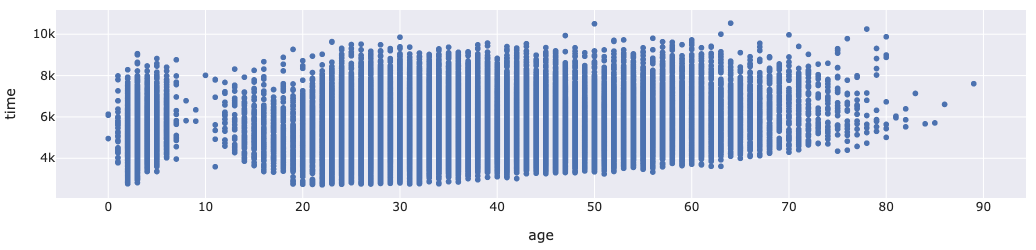

In [4]:
fig = go.Figure(
    data=go.Scattergl(x=df['age'], y=df['time'], mode='markers'),
    layout=dict(width=350, height=250),
)
fig.update_xaxes(title_text='age')
fig.update_yaxes(title_text='time')
fig

This scatter plot contains over 70,000 points. 
Because there are so many points, many of them overlap with each other.
This is a common problem called *over-plotting*.
In this case, over-plotting prevents us from seeing how time and age are
related.
To address over-plotting,
we use smoothing techniques that aggregate data together before plotting.

## Smoothing Techniques to Uncover Shape

The histogram is likely the most familiar type of plot that
uses smoothing.
A histogram aggregates points together by putting points into bins.
Then, it plots one bar for each bin.
For instance, the histogram below plots the distribution of lifespans
for dog breeds.
Above the histogram is a rug plot that draws a single line for every point
in the data.
We can see that even a small amount of data can cause overplotting in the rug
plot.
By smoothing out the points in the rug plot, the histogram shows the shape
of the distribution.

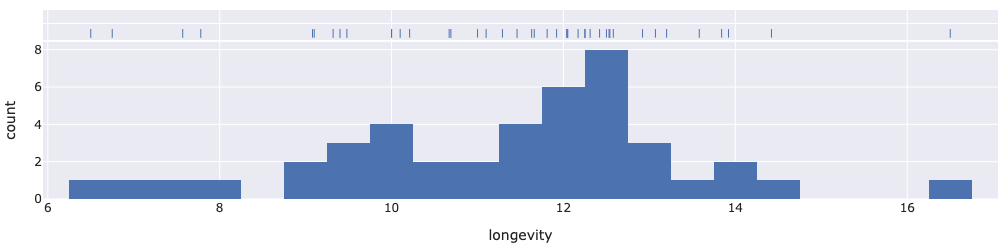

In [16]:
px.histogram(dogs, x="longevity", marginal="rug", nbins=30,
             width=350, height=250)

Another common smoothing technique is *kernel density estimation* (KDE).
A KDE plot shows the distribution using a smooth curve rather than bars.
In the plot below, we show the same histogram of dog longevities
with a KDE curve overlain on top.
We can see the KDE curve shows a similar distribution as the histogram.

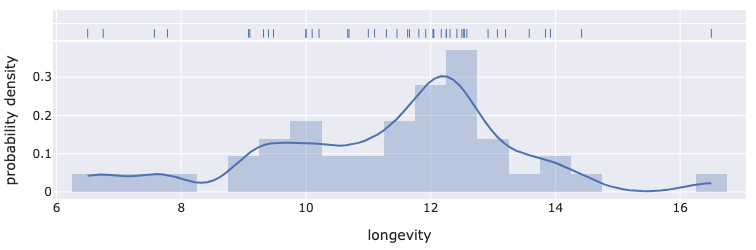

In [122]:
from scipy.stats import gaussian_kde

fig = px.histogram(dogs, x="longevity", marginal="rug",
                   histnorm='probability density', nbins=30,
                   width=450, height=250)

fig.update_traces(marker_color='rgba(76,114,176,0.3)',
                  selector=dict(type='histogram'))

bandwidth = 0.2
xs = np.linspace(min(dogs['longevity']), max(dogs['longevity']), 100)
ys = gaussian_kde(dogs['longevity'], bandwidth)(xs)
curve = go.Scatter(x=xs, y=ys)

fig.add_trace(curve)
fig.update_traces(marker_color='rgb(76,114,176)',
                  selector=dict(type='scatter'))
fig.update_layout(showlegend=False)

What about plots that show two variables of the data, like scatter plots?
We can smooth in two dimensions by using a two-dimensional histogram.
This plot uses rectangular bins to aggregates points together.
Then, it shades the rectangles based on how many points are in each bin.

Let's use this to plot the Cherry Blossom race times against age.

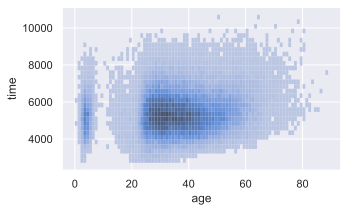

In [139]:
plt.figure(figsize=(5, 3))
sns.histplot(df, x='age', y='time', binwidth=[1, 250]);

Kernel density estimation also works in two dimensions.
When we use KDE in two dimensions, we plot the contours of the resulting
two-dimensional curve.

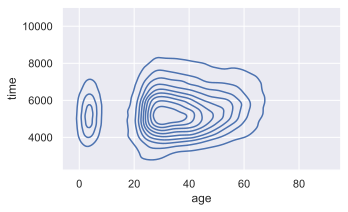

In [142]:
# Takes a while to run!
plt.figure(figsize=(5, 3))
sns.kdeplot(data=df, x='age', y='time');

Using smoothing techniques lets us visualize lots of data at once.
For the Cherry Blossom race, smoothing reveals information about 
the data that was hard to otherwise see.
For example, there's a cluster of points around 5000 seconds
(about 80 minutes).
And, older runners tend to run more slowly than younger runners, but not by
much.
There's also a group of runners under 10 years old, which might point to
issues in the data.

## Principles of Smoothing

Now that we've seen how smoothing is useful for plotting, we turn to
principles of smoothing that we consider while creating visualizations.

**Smoothing Techniques Need Tuning**.
Most smoothing techniques need the data scientist to tune how much
smoothing is applied. For histograms, we need to choose the number of bins.
And KDE plots have a parameter called the "bandwidth" that
works similarly to the number of bins on a histogram.
The left histogram below has too few bins, and the right histogram 
has too many. In both cases, it's hard to see the shape of the distribution.

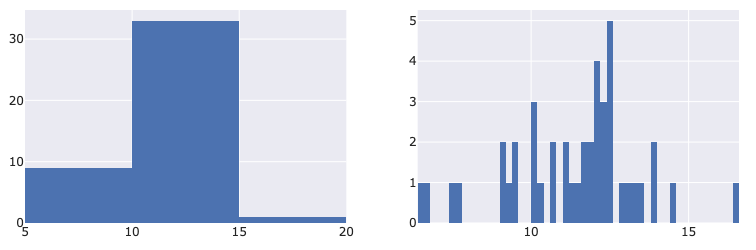

In [83]:
f1 = px.histogram(dogs, x="longevity", nbins=5,
             width=350, height=250)
f2 = px.histogram(dogs, x="longevity", nbins=100,
             width=350, height=250)

left_right(f1, f2, height=250)

When we create visualizations that use smoothing, it's important 
to try several different smoothing amounts to create the most useful
plot.

**Smoothing to Uncover Trends**.
With large amounts of data, we can replace
individual values with aggregates before plotting.
Earlier in this section,
we used a 2D histogram to visualize the Cherry Blossom race data.
Another way to smooth the data is to group together the race times for ages
0-5, 5-10, 10-15, etc., then plot the average time for each group.

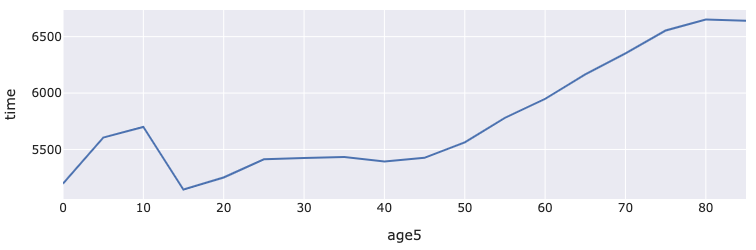

In [158]:
times = (
    df.assign(age5=df['age'] // 5 * 5)
    .groupby('age5')
    ['time']
    .mean()
    .reset_index()
)
px.line(times, x='age5', y='time', width=350, height=250)

This plot also shows that older runners ran slower than younger ones.

**Reducing Shape to a Box-and-Whisker Plot**.
Box-and-whisker plots (also known simply as box plots) give a visual summary
of a few important statistics for a distribution.
Typically, they display the median, 25th percentile, 75th percentile,
the minimum, and the maximum, as shown in {numref}`Figure %s <box_plot>`.

```{figure} figures/box_plot.svg
---
name: box_plot
---

Box plot of dog longevities, with statistics labeled.
```

Box plots aren't as informative as a histogram since histograms show the entire
distribution rather than a few summary statistics.
But box plots are very useful when comparing many groups at once. 
In the plot below, we use multiple box plots instead of a line plot to show 
race times against runner age. This plot 
reveals more information than the simple line plot.

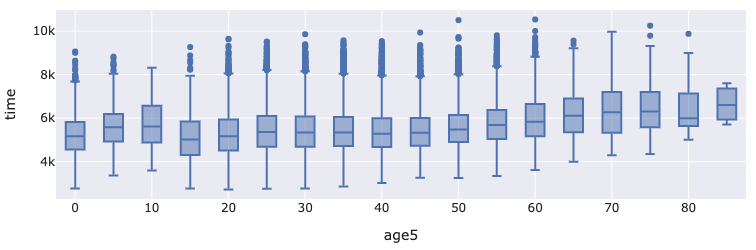

In [167]:
times = (
    df.assign(age5=df['age'] // 5 * 5)
)
px.box(times, x='age5', y='time', width=500, height=250)

**When Not to Smooth**. When we have only a handful of observations, smoothing
techniques can give misleading representations of the data. With just a few
observations, we prefer rug plots over histograms, box plots, and density
curves, and we make scatter plots rather than smooth curves and density
contours.

**Reducing Distributions to Quantiles.**
When we compare two distributions, we can use side-by-side
histograms, or overlay two KDE curves.
However, when two distributions are similar, it can be hard to see the
differences.
For instance, the histograms below show the race times for 25-year-olds 
on the left and 40-year-olds on the right.
It's hard to understand how these distributions are different based on
this plot.

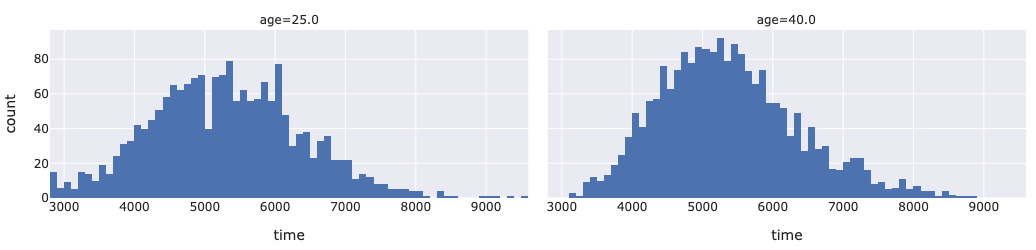

In [180]:
fig = px.histogram(df.query('age in [25, 40]'),
                   x='time', facet_col='age', width=700, height=250)
margin(fig, t=30)

One useful way of comparing distributions is a quantile-quantile plot.
To make this plot, we first compute percentiles (also called quantiles)
for both distributions.
Then, we plot matching percentiles on a scatter plot.

In [191]:
run25 = df.query('age == 25')
run40 = df.query('age == 40')
percs = np.arange(101)
perc25 = np.percentile(run25['time'], percs, interpolation='lower')
perc40 = np.percentile(run40['time'], percs, interpolation='lower')
perc_df = pd.DataFrame({'percentile': percs, 'age25': perc25, 'age40': perc40})
perc_df

percentile   age25   age40
0             0  2820.0  3108.0
1             1  2929.0  3444.0
2             2  3216.0  3625.0
..          ...     ...     ...
98           98  7572.0  7756.0
99           99  7908.0  8067.0
100         100  9502.0  8832.0

[101 rows x 3 columns]

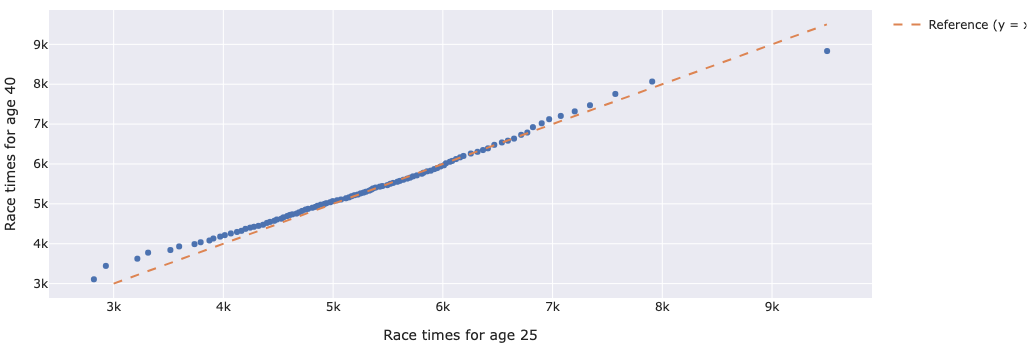

In [204]:
fig = px.scatter(perc_df, x='age25', y='age40', width=500, height=350,
                 labels={'age25': 'Race times for age 25',
                         'age40': 'Race times for age 40'})

fig.add_trace(
    go.Scatter(x=[3000, 9500], y=[3000, 9500],
               mode='lines', line=dict(dash='dash'),
               name='Reference (y = x)')
)

In the quantile-quantile plot, we usually also show the reference line (y = x).
This lets us see that at lower percentiles, 40-year-old runners run slower than
25-year-olds since the points appear above the reference line.
But otherwise, the race times look quite similar; 40-year-olds kept up well
with 25-year-olds.

**Other Ways to Reveal Density in a Scatter Plot**.
There are plenty of other ways to reduce over-plotting in a scatter plot.
For instance, we can make the dots partially transparent so overlapping points
appear darker.
If many observations have the
same values (e.g., when measurements are rounded to the nearest inch),
then we can
add a small amount of random noise to the values to reduce the amount of
over-plotting. This procedure is called "jittering".
Transparency and jittering are convenient for medium-sized data.
However, they don't work very well for large datasets since they still plot
all the points in the data.

## Takeaways

This section introduced the problem of over-plotting, where we have
overlapping points because of a large dataset.
To address this issue, we introduced smoothing techniques that aggregate data
together.
We saw two common examples of smoothing:
histograms and kernel density estimation curves.
Then, we discussed principles of smoothing, such as the need to tune the
smoothing amount, aggregating the data before plotting, and when not to smooth.
In the next section, we'll talk about how to design visualizations to
facilitate meaningful comparisons.